In [293]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from symengine import *
from mimiqcircuits import *
from tqdm import tqdm
from scipy.optimize import minimize

In [294]:
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

In [295]:
n=4
np.random.seed(1234)

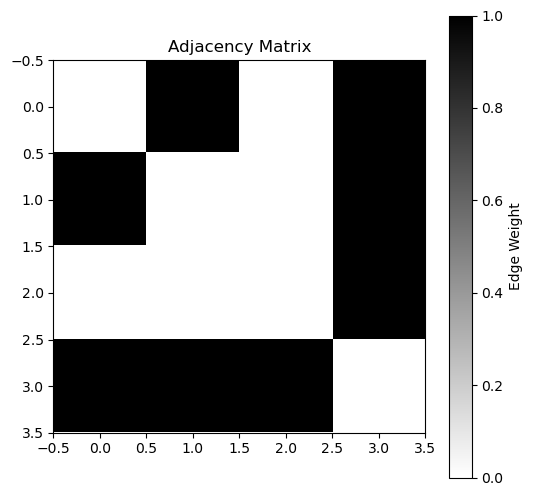

In [296]:
A = np.triu(np.random.randint(0, 2, (n, n)), 1)
D=A+A.T
plot_adjacency_matrix(D)

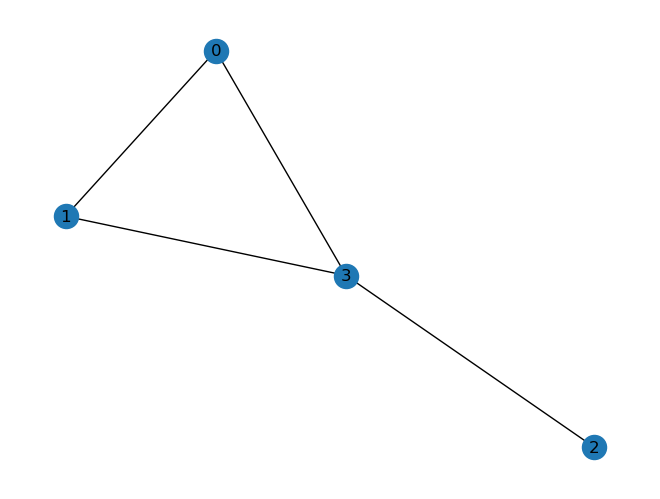

In [297]:
G = nx.Graph(D)
nx.draw(G, with_labels=True)

In [298]:
def cost(X,A):
    c=np.sum(A,axis=0)
    return -X.T @ A @ X+c.T @ X


In [299]:
connect = MimiqConnection(url="https://mimiq.qperfect.io/api")
connect.connect("marco.vassallo02@gmail.com","Eucalipto03")

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 283/3000 minutes
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

In [300]:
def Build_QAOA(B, q, draw=False):
    beta=[symbols(f"beta_{i}") for i in range(q)]
    gamma=[symbols(f"gamma_{i}") for i in range(q)]
    n=len(B) #Qubit number

    c=Circuit() #Circuit definition
    c.push(GateH(), range(0, n))
        
    for k in tqdm(range(0,q), desc="ZAVO FROCIO AL"):

        #Block here
        for i in range(0,n) :
            for j in range(i+1,n):
                A_ij = B[i,j]
                if A_ij != 0:
                    c.push(GateRZZ(gamma[k]*A_ij), i, j)    #The Upeer one is ALWAYS the control one

        #Block Here
        
        c.push(GateRX(beta[k]), range(0,n))
        
    if draw:
        c.draw()

    return c

In [301]:
def Run_QAOA(circuit, beta, gamma, connect):
   dict_beta={f"beta_{i}":beta[i] for i in range(len(beta))}
   dict_gamma={f"gamma_{i}":gamma[i] for i in range(len(gamma))}
   full_dict = {**dict_beta, **dict_gamma}
   ev_circ = circuit.evaluate(full_dict)
   job_id = connect.execute(ev_circ)
   res = connect.get_result(job_id)
   print(res)
   return res

In [302]:
def Optimizer(circuit,Beta_best,Gamma_best,iteration): 
    Cost_best= 0
    for i in tqdm(range(iteration), desc="outer one"):
        Cost=0
        beta = Beta_best + np.random.normal(0,0.2)
        gamma = Gamma_best + np.random.normal(0,0.2)
        state_vector = Run_QAOA(circuit,beta,gamma,connect).histogram()
        for state, measures in tqdm( state_vector.items(), desc="inner one"):
            state=np.array(state.tolist())
            Cost+=cost(state,D)*measures
        if(Cost>Cost_best):
            Cost_best=Cost
            Beta_best=beta
            Gamma_best=gamma
        if(i==iteration-1):
            return max(state_vector, key=state_vector.get)
    return 0

In [303]:
def Run_QAOA_Pussy_cat(params):
    circuit = Build_QAOA(D, 5)
    full_dict = {}
    for i in range(len(params)):
        if i < len(params)/2:
            dict_beta={f"beta_{i}":params[i]}
            full_dict.update(dict_beta)
        else:
            j = i-5
            dict_gamma={f"gamma_{j}":params[i]}
            full_dict.update(dict_gamma)            
    ev_circ = circuit.evaluate(full_dict)
    job_id = connect.execute(ev_circ)
    res = connect.get_result(job_id)
    Cost=0
    Time += res.timing['total']
    for state, measures in tqdm( res.histogram().items(), desc="PUSSYCAT"):
        state=np.array(state.tolist())
        Cost+=cost(state,D)*measures/1000
    return Cost

In [304]:
def Pussy_cat(Beta_best,Gamma_best): 
    params = np.concatenate([Beta_best,Gamma_best])
    result = minimize(Run_QAOA_Pussy_cat,params,method='Nelder-Mead',options={'maxiter': 20})
    return result

In [ ]:
layer_number = 5

Time=0
beta = np.random.uniform(0, np.pi, layer_number)
gamma = np.random.uniform(0, np.pi, layer_number)
val=Pussy_cat(beta,gamma)

ZAVO FROCIO AL: 100%|██████████| 5/5 [00:00<00:00, 10951.19it/s]


In [ ]:
val.final_simplex

(array([[0.89465198, 0.04956053, 2.82031028, 3.22329658, 1.17591944],
        [0.93198776, 0.05013977, 2.88191736, 3.23660187, 1.14450402],
        [0.92356006, 0.05055545, 2.85725323, 3.14936713, 1.15425127],
        [0.94053361, 0.04768967, 2.84327915, 3.17052506, 1.14632415],
        [0.66465167, 0.05035948, 3.02448607, 3.37014172, 1.18254958],
        [1.00534546, 0.04820328, 2.81656122, 3.11171075, 1.20874276]]),
 array([1.596, 1.625, 1.65 , 1.656, 1.682, 1.686]))

In [ ]:
circuit = Build_QAOA(D, 5)

res=Run_QAOA(circuit,beta,gamma,connect )

ZAVO FROCIO AL: 100%|██████████| 5/5 [00:00<00:00, 11895.36it/s]


ValueError: The circuit contains unevaluated symbolic parameters and cannot be processed until all parameters are fully evaluated.

In [ ]:
print(Time)

0


In [ ]:
iteration=1
layer_number = 1
circuit = Build_QAOA(D, layer_number)


beta = np.random.uniform(0, np.pi, layer_number)
gamma = np.random.uniform(0, np.pi, layer_number)
val_=Optimizer(circuit,beta,gamma,iteration)

outer one:   0%|          | 0/1 [00:00<?, ?it/s]

QCSResults:
├── simulator: MIMIQ-StateVector 0.18.2
├── timings:
│    ├── apply time: 9.2335e-05s
│    ├── parse time: 0.000207568s
│    ├── total time: 0.000838088s
│    ├── compression time: 0.000130454s
│    └── sample time: 0.000133471s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"0000" => 208
│    ├── bs"1111" => 187
│    ├── bs"0010" => 97
│    ├── bs"1101" => 91
│    └── bs"0001" => 65
├── 1 executions
├── 0 amplitudes
└── 1000 samples


outer one:   0%|          | 0/1 [00:02<?, ?it/s]


In [ ]:
print(val)
circuit.draw()

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 1.5959999999999999
             x: [ 8.947e-01  4.956e-02  2.820e+00  3.223e+00  1.176e+00]
           nit: 20
          nfev: 35
 final_simplex: (array([[ 8.947e-01,  4.956e-02, ...,  3.223e+00,
                         1.176e+00],
                       [ 9.320e-01,  5.014e-02, ...,  3.237e+00,
                         1.145e+00],
                       ...,
                       [ 6.647e-01,  5.036e-02, ...,  3.370e+00,
                         1.183e+00],
                       [ 1.005e+00,  4.820e-02, ...,  3.112e+00,
                         1.209e+00]]), array([ 1.596e+00,  1.625e+00,  1.650e+00,  1.656e+00,
                        1.682e+00,  1.686e+00]))
        ┌─┐         ┌──────────────┐  ┌──────────────┐                          
 q[0]: ╶┤H├─────────┤0             ├──┤0             ├─────────────────────────╴
        └─┘┌─┐      │  RZZ(gamma_0)│  │      